
=== Dataset: Subclusters.csv ===


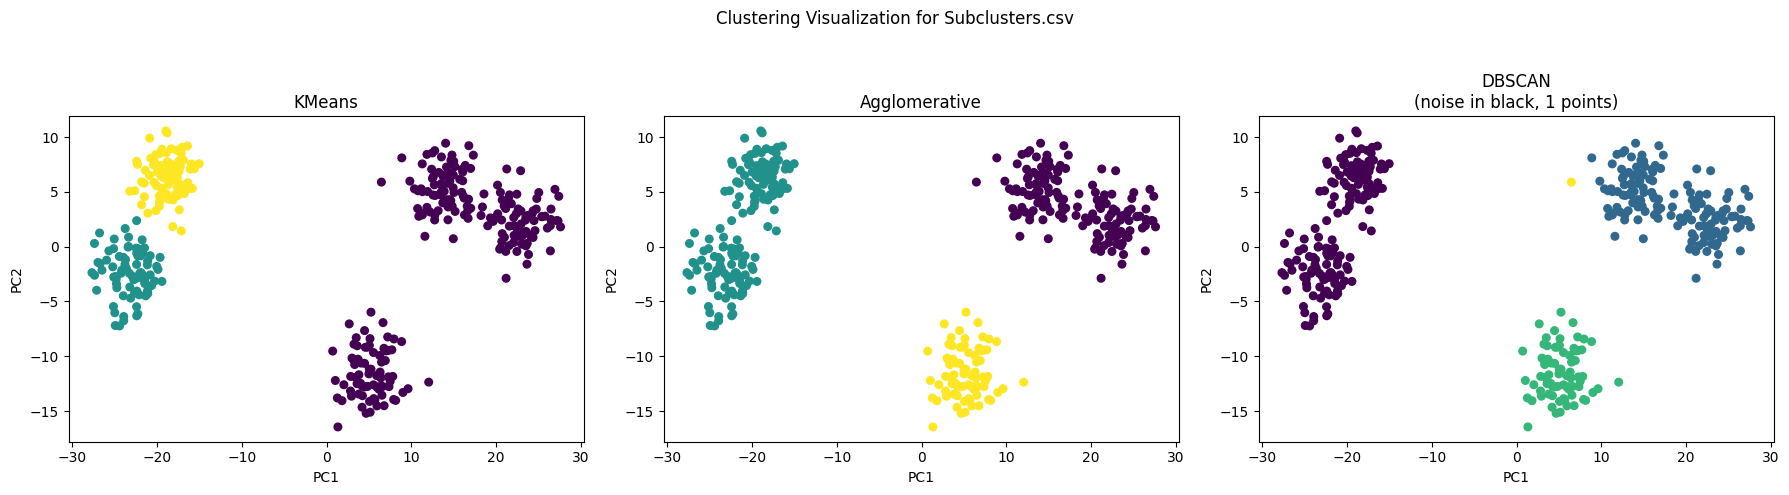


=== Dataset: Skewed.csv ===


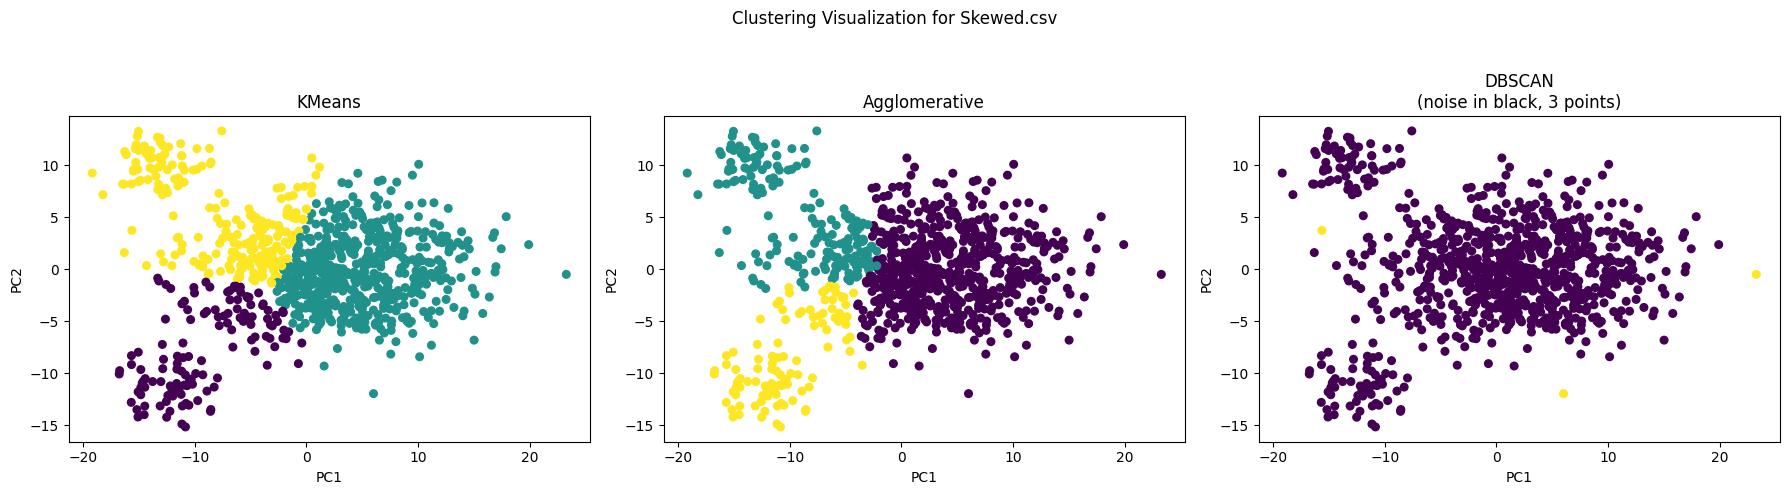


=== Dataset: Compact.csv ===


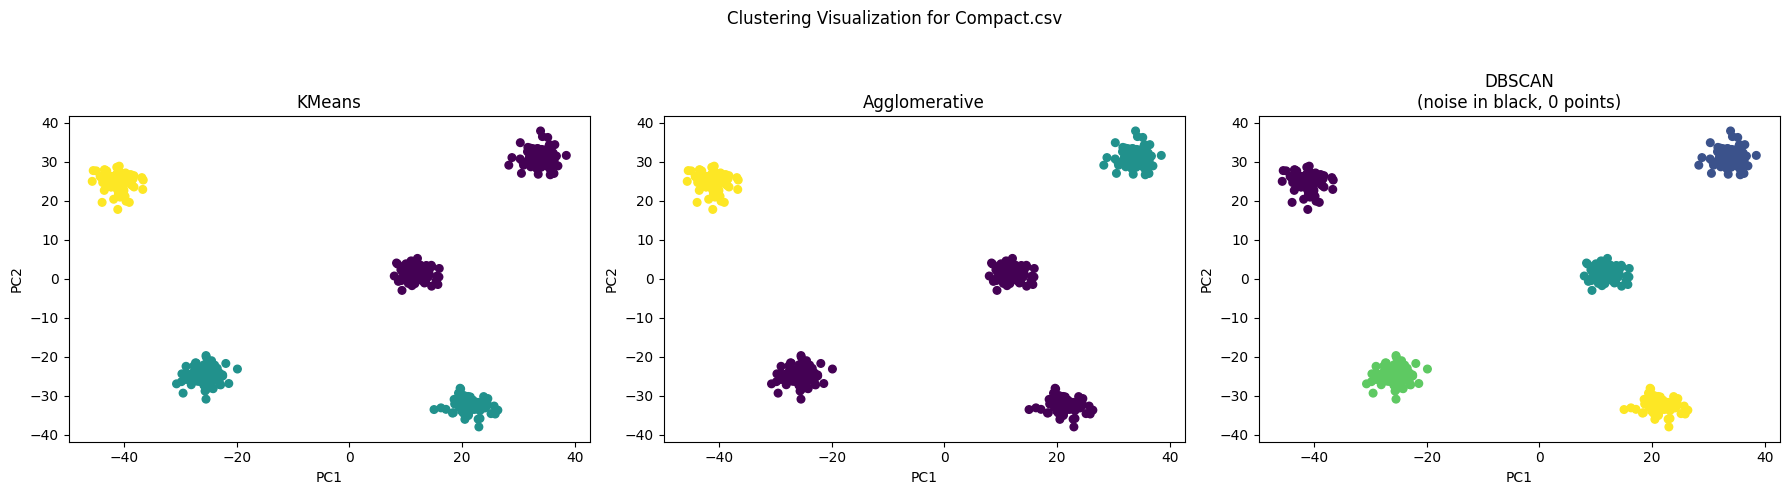


=== Dataset: wellSeperated.csv ===


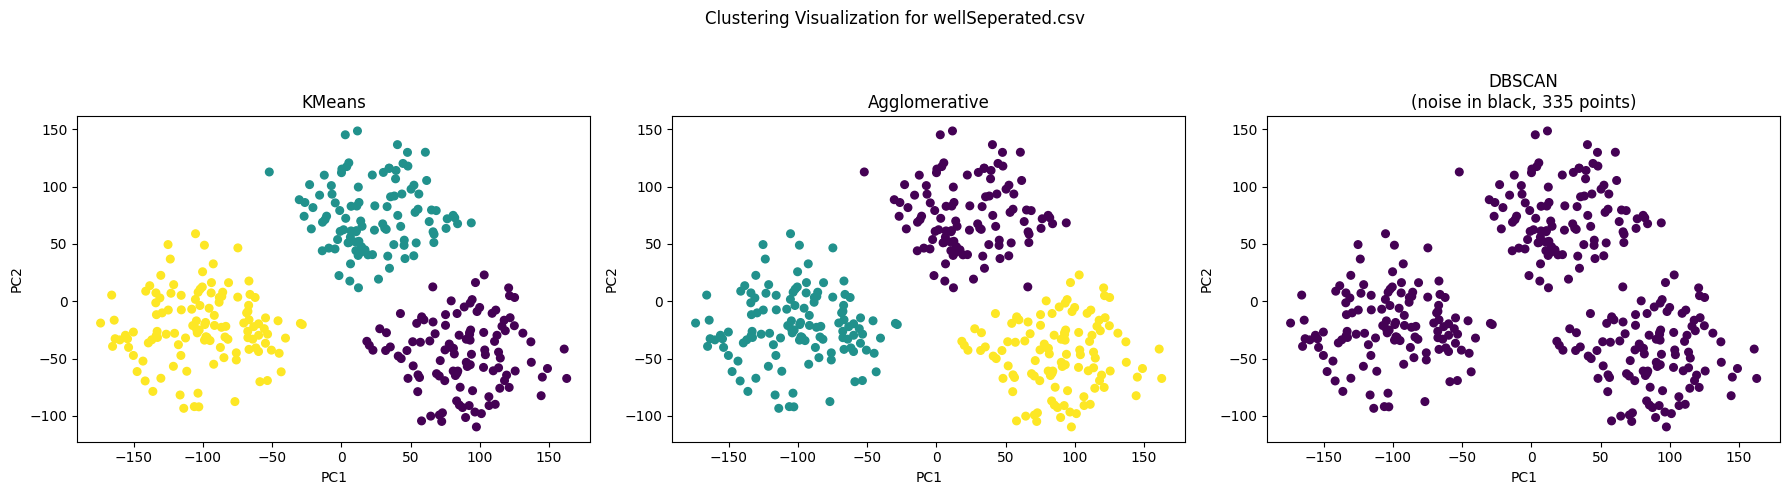


Score Table:
| Dataset           |   KMeans Silhouette |   KMeans IntraDist |   Agglom Silhouette |   Agglom IntraDist |   DBSCAN Silhouette |   DBSCAN IntraDist |   DBSCAN Noise |
|:------------------|--------------------:|-------------------:|--------------------:|-------------------:|--------------------:|-------------------:|---------------:|
| Subclusters.csv   |            0.633462 |   775857           |            0.738949 |   372498           |            0.740734 |   368549           |              1 |
| Skewed.csv        |            0.429385 |        2.76699e+06 |            0.441312 |        3.32004e+06 |          nan        |        9.51292e+06 |              3 |
| Compact.csv       |            0.63072  |        1.19706e+06 |            0.610037 |        1.76069e+06 |            0.91178  |   111822           |              0 |
| wellSeperated.csv |            0.613946 |        2.06364e+06 |            0.612632 |        2.0649e+06  |          nan        |      nan        

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA

filenames = ['Subclusters.csv', 'Skewed.csv', 'Compact.csv', 'wellSeperated.csv']
datasets = {f: pd.read_csv(f) for f in filenames}
results = []

for name, data in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    X = data.select_dtypes(include=[np.number]).values

    # KMeans
    k = 3
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    sil_k = silhouette_score(X, kmeans_labels)
    intra_k = np.sum([
        np.sum(pairwise_distances(X[kmeans_labels == c, :]))
        for c in np.unique(kmeans_labels)
    ])

    # Agglomerative (Complete linkage)
    agg = AgglomerativeClustering(n_clusters=k, linkage='complete')
    agg_labels = agg.fit_predict(X)
    sil_a = silhouette_score(X, agg_labels)
    intra_a = np.sum([
        np.sum(pairwise_distances(X[agg_labels == c, :]))
        for c in np.unique(agg_labels)
    ])

    # DBSCAN (tune eps and min_samples for each dataset: example values)
    dbscan = DBSCAN(eps=3.0, min_samples=5)
    db_labels = dbscan.fit_predict(X)
    # Count noise points (label == -1)
    n_noise = np.sum(db_labels == -1)
    mask = db_labels != -1
    if np.unique(db_labels[mask]).shape[0] > 1:
        sil_d = silhouette_score(X[mask], db_labels[mask])
    else:
        sil_d = np.nan
    intra_d = np.nan if n_noise == len(X) else np.sum([
        np.sum(pairwise_distances(X[np.logical_and(mask, db_labels == c), :]))
        for c in np.unique(db_labels[mask])
    ])

    # Table row
    results.append({
        "Dataset": name,
        "KMeans Silhouette": sil_k,
        "KMeans IntraDist": intra_k,
        "Agglom Silhouette": sil_a,
        "Agglom IntraDist": intra_a,
        "DBSCAN Silhouette": sil_d,
        "DBSCAN IntraDist": intra_d,
        "DBSCAN Noise": n_noise
    })

    # Scatter plots with cluster colorings
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Clustering Visualization for {name}")

    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    axs[0].scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_labels, cmap='viridis', s=30)
    axs[0].set_title("KMeans")
    axs[0].set_xlabel("PC1"); axs[0].set_ylabel("PC2")

    axs[1].scatter(X_2d[:, 0], X_2d[:, 1], c=agg_labels, cmap='viridis', s=30)
    axs[1].set_title("Agglomerative")
    axs[1].set_xlabel("PC1"); axs[1].set_ylabel("PC2")

    # For DBSCAN, noise points (-1) colored black
    colors = db_labels.copy()
    colors[db_labels == -1] = max(db_labels) + 1
    axs[2].scatter(X_2d[:, 0], X_2d[:, 1], c=colors, cmap='viridis', s=30)
    axs[2].set_title(f"DBSCAN\n(noise in black, {n_noise} points)")
    axs[2].set_xlabel("PC1"); axs[2].set_ylabel("PC2")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Display results in a table (use pandas dataframe for markdown/report)
result_df = pd.DataFrame(results)
print("\nScore Table:")
print(result_df.to_markdown(index=False))
